# Walmart Store Sales Forecast - In Progress

## Background Information

Data are provided by Walmart with 45 different stores located in different regions. Each store contains many departments and we will need to project the sales for each department in each store.  Also the holidays markdown are included in the dataset as well. Data is available at: https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data


1. stores.csv: This file contains anonymized information about the 45 stores, indicating the type and size of store.


2. train.csv: This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

    Store - the store number <br>
    Dept - the department number <br>
    Date - the week <br>
    Weekly_Sales -  sales for the given department in the given store <br>
    IsHoliday - whether the week is a special holiday week <br>
    

3. test.csv: This file is identical to train.csv, except the actual weekly sales have been withheld. The task is to predict the sales for each store.


4. features.csv: This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

    Store - the store number
    Date - the week
    Temperature - average temperature in the region
    Fuel_Price - cost of fuel in the region
    MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
    CPI - the consumer price index
    Unemployment - the unemployment rate
    IsHoliday - whether the week is a special holiday week



# Import Packages and Data

In [1]:
#import packages
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm 

pd.set_option('display.max_columns',1000)

import warnings
warnings.filterwarnings('ignore')

import datetime 

In [2]:
# import data 
train = pd.read_csv("Data/train.csv")
test =pd.read_csv("Data/test.csv")
stores = pd.read_csv("Data/stores.csv")
features = pd.read_csv("Data/features.csv")

In [3]:
#inspect data
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [5]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [6]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


# Data Cleaning and manipulation

In the data cleaning, I will perform the following steps:

1.  Create an new column Weekly_Sales so we can combine train and test for cleaning purpose
2.  Create a store_id column by combining store number, department number, and date for training and testing data. Based on the original data, each row is record as weekly sales for that particular department in that store on the particular date. However, there is no unique identifier that we can identify each records for training and testing. 
3. Combine training and test for clean purpose
4. Join features tables and store tables to the new combined and train df
5. Replace markdown price Nan to 0 since Nan means no markdown at that time. 
6. Change date column to date format
6. Replace missing values 
7. Replace categorical values to dummy or numbers. If the category has more than 2 categories change to dummy otherwise replace with 1 or 0


## 1. Create an new column Weekly_Sales with test with null value

In [7]:
test['Weekly_Sales']= np.NaN

## 2. Create a store_id by combing store number, department number, and date for train/test

In [8]:
train['Store_Id'] = train[train.columns[:3]].apply(lambda x: '_'.join(x.astype(str)), axis=1)

In [9]:
## 2b. Create a store_id by combing store number, department number, and date for test

test['Store_Id'] = test[test.columns[:3]].apply(lambda x: '_'.join(x.astype(str)), axis=1)


#sanity check 
display(train.head())
display(test.head())

,Store,Dept,Date,Weekly_Sales,IsHoliday,Store_Id
0,1,1,2010-02-05,24924.50,False,1_1_2010-02-05
1,1,1,2010-02-12,46039.49,True,1_1_2010-02-12
2,1,1,2010-02-19,41595.55,False,1_1_2010-02-19
3,1,1,2010-02-26,19403.54,False,1_1_2010-02-26
4,1,1,2010-03-05,21827.90,False,1_1_2010-03-05


,Store,Dept,Date,IsHoliday,Weekly_Sales,Store_Id
0,1,1,2012-11-02,False,NaN,1_1_2012-11-02
1,1,1,2012-11-09,False,NaN,1_1_2012-11-09
2,1,1,2012-11-16,False,NaN,1_1_2012-11-16
3,1,1,2012-11-23,True,NaN,1_1_2012-11-23
4,1,1,2012-11-30,False,NaN,1_1_2012-11-30


## 3. Combine Train and test data 

In [10]:
data = pd.concat([train,test])

#sanity check 
print(f'Shape for trian:{train.shape}')
print(f'Shape for test:{test.shape}')
print(f'Shape for data: {data.shape}')

data.head()

Shape for trian:(421570, 6)
Shape for test:(115064, 6)
Shape for data: (536634, 6)


,Date,Dept,IsHoliday,Store,Store_Id,Weekly_Sales
0,2010-02-05,1,False,1,1_1_2010-02-05,24924.50
1,2010-02-12,1,True,1,1_1_2010-02-12,46039.49
2,2010-02-19,1,False,1,1_1_2010-02-19,41595.55
3,2010-02-26,1,False,1,1_1_2010-02-26,19403.54
4,2010-03-05,1,False,1,1_1_2010-03-05,21827.90


## 4 Join stores to data. 

In [11]:
#join stores to data with Store number
data1 = pd.merge(data, stores, on='Store')

#sanity check
data1.head()

,Date,Dept,IsHoliday,Store,Store_Id,Weekly_Sales,Type,Size
0,2010-02-05,1,False,1,1_1_2010-02-05,24924.50,A,151315
1,2010-02-12,1,True,1,1_1_2010-02-12,46039.49,A,151315
2,2010-02-19,1,False,1,1_1_2010-02-19,41595.55,A,151315
3,2010-02-26,1,False,1,1_1_2010-02-26,19403.54,A,151315
4,2010-03-05,1,False,1,1_1_2010-03-05,21827.90,A,151315


In [12]:
# join features to data1 where store and date are multiple contidions and set store_id as index
df = pd.merge(data1, features, left_on=['Store','Date'], right_on=['Store', 'Date'])
#sanity check on df
df.head()

,Date,Dept,IsHoliday_x,Store,Store_Id,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,2010-02-05,1,False,1,1_1_2010-02-05,24924.50,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,2010-02-05,2,False,1,1_2_2010-02-05,50605.27,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2,2010-02-05,3,False,1,1_3_2010-02-05,13740.12,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
3,2010-02-05,4,False,1,1_4_2010-02-05,39954.04,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
4,2010-02-05,5,False,1,1_5_2010-02-05,32229.38,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False


## 4. Replace MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5 Nan value to 0

In [13]:
#using for loops to replace madkdown columns Nan values to 0
cols = ['MarkDown1', 'MarkDown2','MarkDown3','MarkDown4','MarkDown5']

for i in cols:
    df[i]= np.nan_to_num(df[i])

df.head()

,Date,Dept,IsHoliday_x,Store,Store_Id,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,2010-02-05,1,False,1,1_1_2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
1,2010-02-05,2,False,1,1_2_2010-02-05,50605.27,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
2,2010-02-05,3,False,1,1_3_2010-02-05,13740.12,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
3,2010-02-05,4,False,1,1_4_2010-02-05,39954.04,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
4,2010-02-05,5,False,1,1_5_2010-02-05,32229.38,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False


## Change Date column to date formate 

In [14]:
#Check Df summary info 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536634 entries, 0 to 536633
Data columns (total 18 columns):
Date            536634 non-null object
Dept            536634 non-null int64
IsHoliday_x     536634 non-null bool
Store           536634 non-null int64
Store_Id        536634 non-null object
Weekly_Sales    421570 non-null float64
Type            536634 non-null object
Size            536634 non-null int64
Temperature     536634 non-null float64
Fuel_Price      536634 non-null float64
MarkDown1       536634 non-null float64
MarkDown2       536634 non-null float64
MarkDown3       536634 non-null float64
MarkDown4       536634 non-null float64
MarkDown5       536634 non-null float64
CPI             498472 non-null float64
Unemployment    498472 non-null float64
IsHoliday_y     536634 non-null bool
dtypes: bool(2), float64(10), int64(3), object(3)
memory usage: 70.6+ MB


In [15]:
#change Date from string to date formate
df['Date'] = pd.to_datetime(df['Date'], format ='%Y-%m-%d')

In [16]:
#sanity check on date column
type(df['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

## Replace missing values for CPI and unemployment

In [17]:
#get NAN CPI in the features table
display(features['CPI'].isnull().sum())

#See first 5 rows with CPI missing. 
display(features[features['CPI'].isnull()].head())



585

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
169,1,2013-05-03,66.66,3.386,2298.63,2.00,129.90,55.46,1301.04,NaN,NaN,False
170,1,2013-05-10,63.90,3.392,4624.61,83.88,42.38,1618.31,8144.90,NaN,NaN,False
171,1,2013-05-17,69.53,3.454,16170.50,92.00,8.32,4127.24,6206.97,NaN,NaN,False
172,1,2013-05-24,77.19,3.494,7959.89,178.00,1621.47,3152.57,2938.70,NaN,NaN,False
173,1,2013-05-31,78.02,3.466,2369.77,142.45,475.35,45.55,2056.84,NaN,NaN,False


In [18]:
#get NAN Unemployment in the features table
features['Unemployment'].isnull().sum()


585

In [19]:
#check to see whether the missing CPI is also missing unemployment data 
features[features['CPI'].isnull()]['Unemployment'].isnull().sum()

585

In [20]:
#check how many years of CPI and Unemployment are missing in df
pd.DatetimeIndex(df[df['CPI'].isnull()]['Date']).year.value_counts()

2013    38162
Name: Date, dtype: int64

In [21]:
#check on how many years in the data
pd.DatetimeIndex(df['Date']).year.value_counts()

2012    154227
2011    153453
2010    140679
2013     88275
Name: Date, dtype: int64

Based on the aboved information, we can see the missing values for CPI and Unemployment rate are in 2013. We can check the average CPI and unemployment for each year and use the median number or average number based on the distribution of the avgerage store CPI to fill in the null value for 2013. Based on the null value testing of CPI and Unemployment, I can see that all of the rows that are missing CPI are also missing unemployment. 

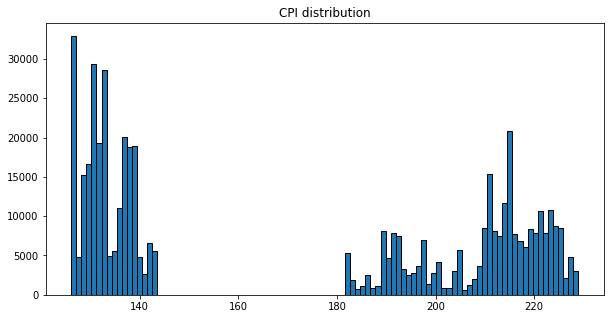

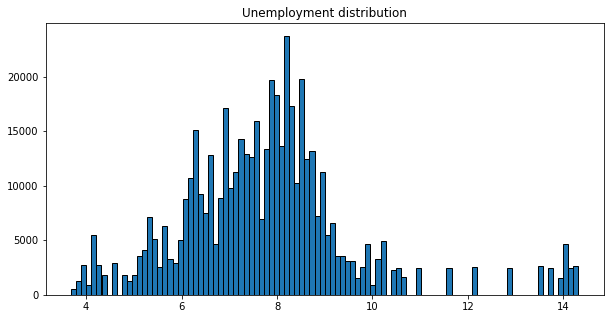

In [22]:
#check on the distribution of CPI and unemployment rate

plt.figure(figsize= (10,5))
plt.hist(df['CPI'], edgecolor = 'black', bins = 100)
plt.title('CPI distribution')
plt.show()

plt.figure(figsize=(10,5))
plt.hist(df['Unemployment'], edgecolor ='black', bins = 100)
plt.title('Unemployment distribution')
plt.show()

In [23]:
#get the stats info for CPI and Unemployment columns
df[['CPI','Unemployment']].describe()

,CPI,Unemployment
count,498472.000000,498472.000000
mean,172.090481,7.791888
std,39.542149,1.865076
min,126.064000,3.684000
25%,132.521867,6.623000
50%,182.442420,7.795000
75%,213.748126,8.549000
max,228.976456,14.313000


In [24]:
#get the mean, medium of the CPI for each store in 2010,2011,2012 
cpi_summary =df.groupby(['Store']).agg({'CPI':['mean','median']})

#unlist the column names
cpi_summary.columns = ['mean', 'median']

#add a column for mean, median difference
cpi_summary['difference'] = cpi_summary['mean'] - cpi_summary['median']

#view the result
cpi_summary

,mean,median,difference
Store,,,
1,217.271077,216.041053,1.230025
2,216.928356,215.694438,1.233918
3,220.704280,219.741491,0.962789
4,129.197705,129.430600,-0.232895
5,217.860702,216.603308,1.257393
6,218.853379,217.579751,1.273629
7,194.734315,194.809971,-0.075656
8,220.737076,219.444244,1.292831
9,220.993589,219.974642,1.018947


Based on the cpi summary table we can see that the average cpi for each store across three years is very similar to the mean of each store across three years. Therefore, I will simiply use the mean of each store across three years to fill the null values for each store in the df. 

In [25]:
# fill CPI na with mean of each store across three years

nulls = df.loc[df['CPI'].isnull(), 'Store']

df.loc[df['CPI'].isnull(),'CPI']= cpi_summary['mean'].loc[nulls].values

#sanity check 
df['CPI'].isnull().sum()

0

In [26]:
#get the mean, medium of the Unemployment for each store from 2010-2012 
unemployment_summary = df.groupby(['Store']).agg({'Unemployment':['mean','median']})

#unlist the column names
unemployment_summary.columns = ['mean', 'median']

#add a column for mean, median difference
unemployment_summary['difference'] = unemployment_summary['mean'] - unemployment_summary['median']

#view the result
unemployment_summary

,mean,median,difference
Store,,,
1,7.441328,7.742,-0.300672
2,7.402505,7.852,-0.449495
3,7.004116,7.343,-0.338884
4,5.648079,5.644,0.004079
5,6.163330,6.465,-0.301670
6,6.411231,6.855,-0.443769
7,8.376465,8.595,-0.218535
8,5.947410,6.262,-0.314590
9,5.923359,6.380,-0.456641


Similar to CPI, the difference between mean and median for the 3 year unemployment is not significant. Therefore, I will use similar method, using mean of the three years for each store to fill the unemployment nan values. 

In [27]:
# fill unemployment na with mean of each store across three years

nulls_u = df.loc[df['Unemployment'].isnull(), 'Store']

df.loc[df['Unemployment'].isnull(),'Unemployment']= unemployment_summary['mean'].loc[nulls_u].values

#sanity check 
df['Unemployment'].isnull().sum()

0

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536634 entries, 0 to 536633
Data columns (total 18 columns):
Date            536634 non-null datetime64[ns]
Dept            536634 non-null int64
IsHoliday_x     536634 non-null bool
Store           536634 non-null int64
Store_Id        536634 non-null object
Weekly_Sales    421570 non-null float64
Type            536634 non-null object
Size            536634 non-null int64
Temperature     536634 non-null float64
Fuel_Price      536634 non-null float64
MarkDown1       536634 non-null float64
MarkDown2       536634 non-null float64
MarkDown3       536634 non-null float64
MarkDown4       536634 non-null float64
MarkDown5       536634 non-null float64
CPI             536634 non-null float64
Unemployment    536634 non-null float64
IsHoliday_y     536634 non-null bool
dtypes: bool(2), datetime64[ns](1), float64(10), int64(3), object(2)
memory usage: 90.6+ MB


In [29]:
# drop extra column IsHoliday_y
df = df.drop(['IsHoliday_y'], axis=1)

## Parse out year, month 

I will parse out year, month from the date columns and create two more new columns Date_year, and Date_month as addition to the features. I also tried to create a new feature Day of the week. However, after review the data, all of the reports are on thursday. So day of week would not be useful.  

In [30]:
#create new columns year, month, and day from the date time stamp


df['Date_year']=pd.Series(pd.DatetimeIndex(df['Date']).year)
df['Date_month']=pd.Series(pd.DatetimeIndex(df['Date']).month)


In [31]:
#check on day of week to see if they are all on the same day.
day_of_week = pd.Series(pd.DatetimeIndex(df['Date']).dayofweek)
print(f'Day of week in the data: {day_of_week.value_counts()}')

Day of week in the data: 4    536634
Name: Date, dtype: int64


# Data Exploration

In [34]:
df.shape

(536634, 16)

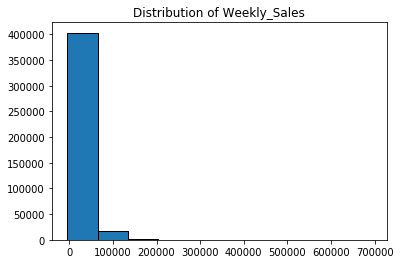

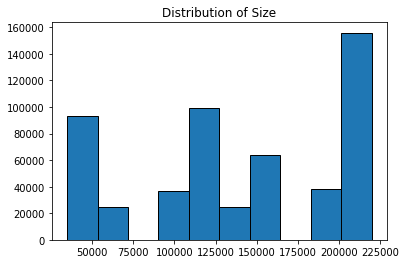

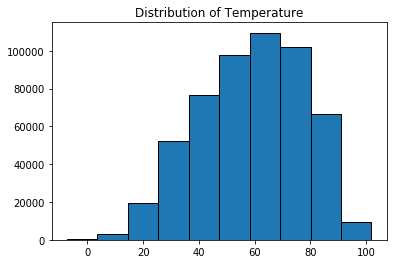

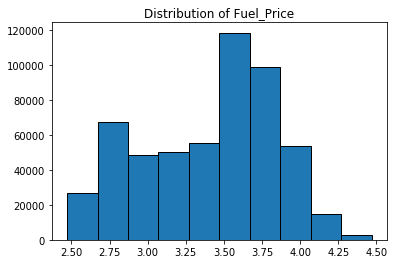

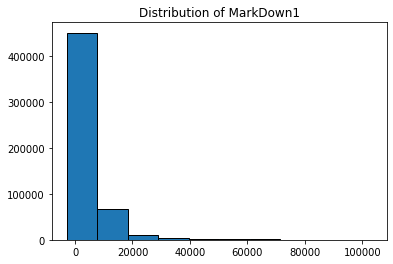

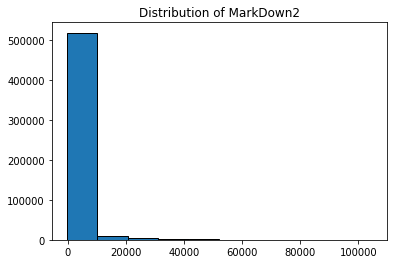

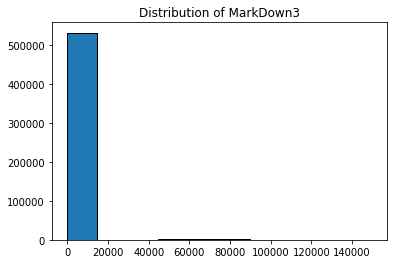

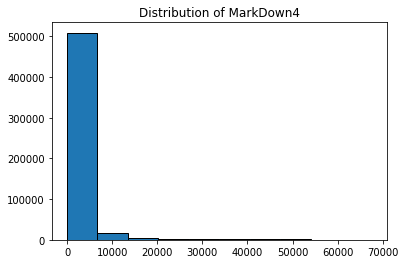

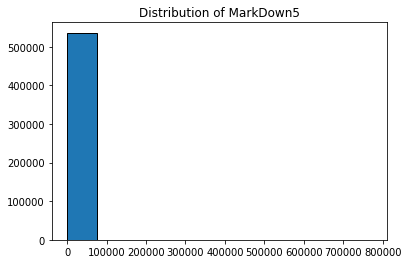

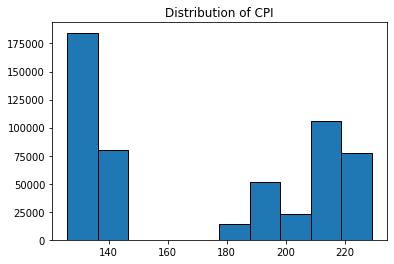

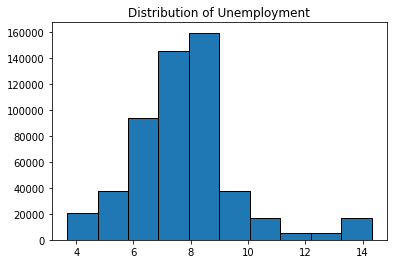

In [35]:
#plot histgram of each numerical columns to visulize the distribution 

#column index with numeric column
numeric_col = [4,6,7,8,9,10,11,12,13,14,15]

for i in numeric_col:  
    plt.hist(df[df.columns[i]], edgecolor='black')
    plt.title(f'Distribution of {df.columns[i]}')
    plt.show()

Based on the above histogram, Weekly sales, and all 5 markdown seems to have a skewed distribution. We may need to take a log to smooth out the distribution in the modeling part. 

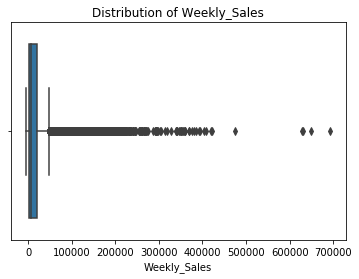

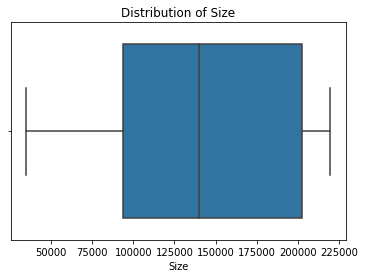

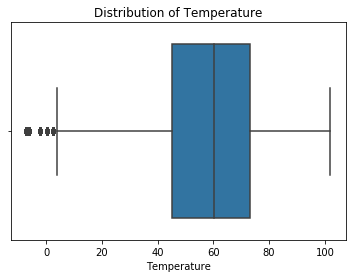

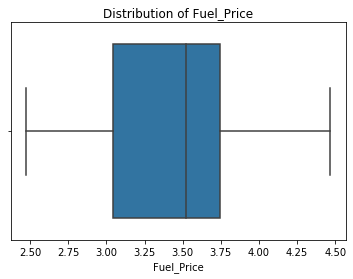

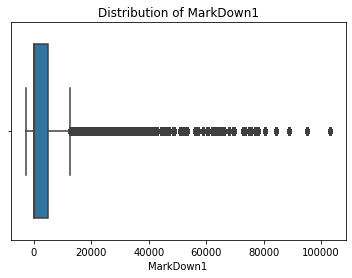

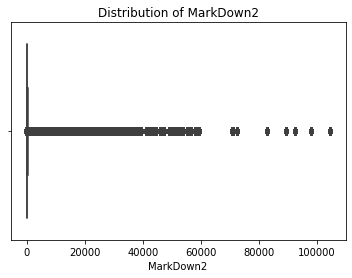

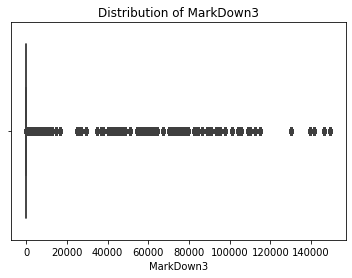

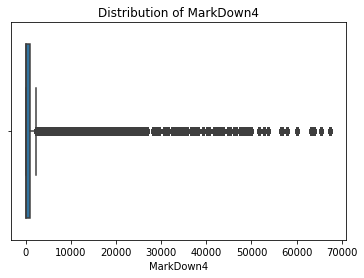

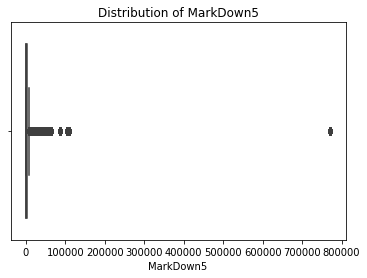

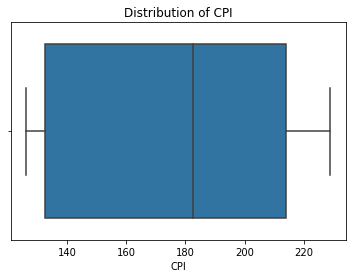

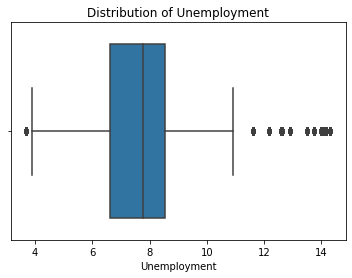

In [36]:
# visualize outlier for those distribution

numeric_col = [4,6,7,8,9,10,11,12,13,14,15]

for i in numeric_col:  
    sns.boxplot(df[df.columns[i]])
    plt.title(f'Distribution of {df.columns[i]}')
    plt.show()

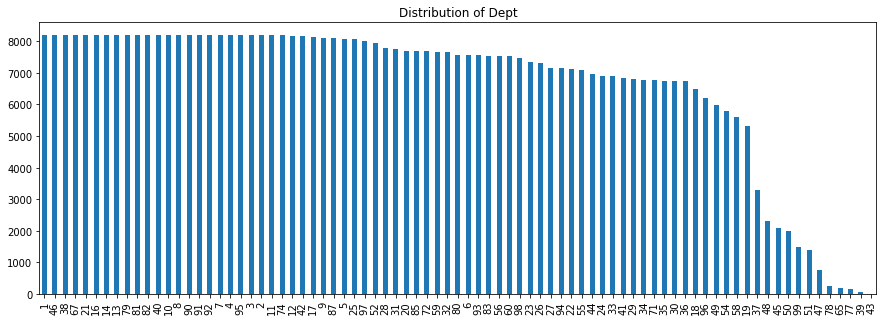

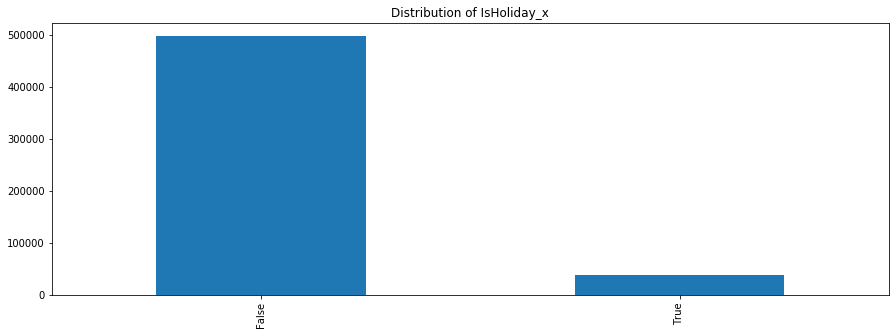

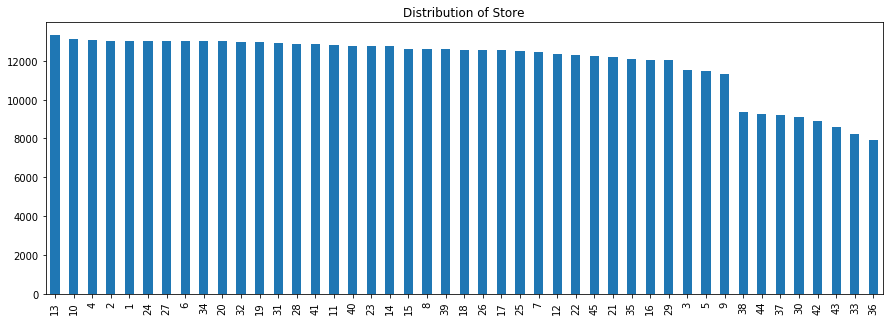

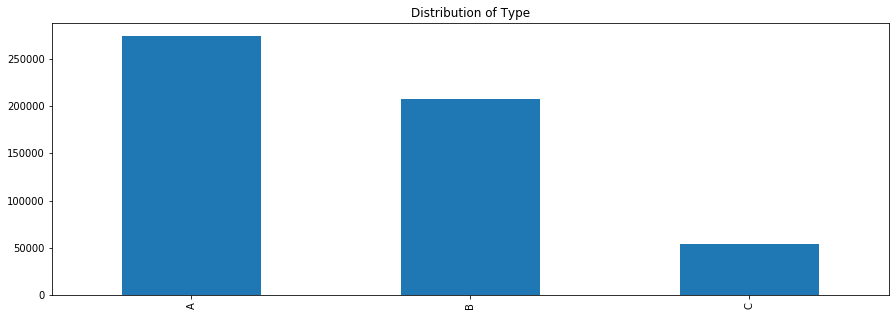

In [37]:
#plot the categorical column distribution

cat_col = [1,2,3,5]


for j in cat_col: 
    plt.figure(figsize=(15,5))
    df[df.columns[j]].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {df.columns[j]}')
    plt.show()
    

In [46]:
df.columns

Index(['Date', 'Dept', 'IsHoliday_x', 'Store', 'Weekly_Sales', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'], dtype='object')

# Modeling


## Create dummies

In [32]:
#Replace boolean and categorical column (Dept, IsHoliday_x, Store, Type) to numeric dummy

df1 = df.copy()
df1['IsHoliday_x'].replace(to_replace={False:0, True:1}, inplace=True)

#change dept, store to string for encoding
df1['Store'] = df1['Store'].apply(str)
df1['Dept'] = df1['Dept'].apply(str)
df1['Date_year'] = df1['Date_year'].apply(str)
df1['Date_month'] = df1['Date_month'].apply(str)

In [33]:
df1.columns

Index(['Date', 'Dept', 'IsHoliday_x', 'Store', 'Store_Id', 'Weekly_Sales', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Date_year', 'Date_month'], dtype='object')

In [34]:
#set store id as index
df1 = df1.set_index(['Store_Id'])

In [35]:
#one-hot encoding dept, store, type since they have more than 2 categories
df2 = pd.get_dummies(df1)

#sanity check
print(f'Shape of original df: {df1.shape}')
print(f'Shape of df1 with dummies: {df2.shape}')

Shape of original df: (536634, 18)
Shape of df1 with dummies: (536634, 158)


In [36]:
#visual inspect
df2.head()

,Date,IsHoliday_x,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Dept_1,Dept_10,Dept_11,Dept_12,Dept_13,Dept_14,Dept_16,Dept_17,Dept_18,Dept_19,Dept_2,Dept_20,Dept_21,Dept_22,Dept_23,Dept_24,Dept_25,Dept_26,Dept_27,Dept_28,Dept_29,Dept_3,Dept_30,Dept_31,Dept_32,Dept_33,Dept_34,Dept_35,Dept_36,Dept_37,Dept_38,Dept_39,Dept_4,Dept_40,Dept_41,Dept_42,Dept_43,Dept_44,Dept_45,Dept_46,Dept_47,Dept_48,Dept_49,Dept_5,Dept_50,Dept_51,Dept_52,Dept_54,Dept_55,Dept_56,Dept_58,Dept_59,Dept_6,Dept_60,Dept_65,Dept_67,Dept_7,Dept_71,Dept_72,Dept_74,Dept_77,Dept_78,Dept_79,Dept_8,Dept_80,Dept_81,Dept_82,Dept_83,Dept_85,Dept_87,Dept_9,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Store_1,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_2,Store_20,Store_21,Store_22,Store_23,Store_24,Store_25,Store_26,Store_27,Store_28,Store_29,Store_3,Store_30,Store_31,Store_32,Store_33,Store_34,Store_35,Store_36,Store_37,Store_38,Store_39,Store_4,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Store_5,Store_6,Store_7,Store_8,Store_9,Type_A,Type_B,Type_C,Date_year_2010,Date_year_2011,Date_year_2012,Date_year_2013,Date_month_1,Date_month_10,Date_month_11,Date_month_12,Date_month_2,Date_month_3,Date_month_4,Date_month_5,Date_month_6,Date_month_7,Date_month_8,Date_month_9
Store_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1_1_2010-02-05,2010-02-05,0,24924.50,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1_2_2010-02-05,2010-02-05,0,50605.27,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1_3_2010-02-05,2010-02-05,0,13740.12,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1_4_2010-02-05,2010-02-05,0,39954.04,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1_5_2010-02-05,2010-02-05,0,32229.38,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [37]:
#Separate out train and test data for modeling and prediction
cleaned_test = df2[df2['Weekly_Sales'].isnull()]
cleaned_train = df2.loc[df2['Weekly_Sales'].notnull()]

#sanity check
display(cleaned_train['Weekly_Sales'].isnull().sum())
display(cleaned_test['Weekly_Sales'].isnull().sum())

0

115064

## Sklearn package import

In [38]:
## import sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Train Test Split

In [39]:
#setting up X, and y from cleaned_train
y = cleaned_train['Weekly_Sales']
X = cleaned_train.drop(['Date','Weekly_Sales'], axis=1)

#split the data into Train, test 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state= 1)

#sanity check 
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (295099, 156)
y_train Shape: (295099,)
X_test Shape: (126471, 156)
y_test Shape: (126471,)


## Linear Regression with Stats model

In [271]:
from scipy import stats
import statsmodels.api as sm 

X_con = sm.add_constant(X_train)
smlinear = sm.OLS(y_train,X_con).fit()

# to get the summary numbers for the model
smlinear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     3910.
Date:                Fri, 20 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:38:57   Log-Likelihood:            -3.2200e+06
No. Observations:              295099   AIC:                         6.440e+06
Df Residuals:                  294951   BIC:                         6.442e+06
Df Model:                         147                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3789.4332   2011.775     -1.884      0.060   -7732.456     153.589
IsHoliday_x      136.1272    112.030      1.215      0.224     -83.448     355.703
Size               0.1223      0.001     85.934      0.000       0.119       0.125
Temperature       14.6099      4.649      3.142      0.002       5.497      23.723
Fuel_Price        58.9909    177.260      0.333      0.739    -288.433     406.415
MarkDown1          0.0019      0.009      0.205      0.837      -0.016       0.020
MarkDown2         -0.0511      0.005     -9.724      0.000      -0.061      -0.041
MarkDown3          0.1036      0.005     21.042      0.000       0.094       0.113
MarkDown4         -0.0163      0.012     -1.332      0.183      -0.040       0.008
MarkDown5         -0.0063      0.007     -0.883      0.377      -0.020       0.008
CPI               47.5649     21.498      2.213      0.027       5.430      89.700
Unemployment    -631.2386     61.429    -10.276      0.000    -751.639    -510.839
Dept_1          6361.8098    220.338     28.873      0.000    5929.953    6793.666
Dept_10         5434.8646    220.381     24.661      0.000    5002.925    5866.804
Dept_11         1714.2490    220.544      7.773      0.000    1281.989    2146.509
Dept_12        -8703.8002    219.933    -39.575      0.000   -9134.863   -8272.738
Dept_13          1.78e+04    220.905     80.566      0.000    1.74e+04    1.82e+04
Dept_14         2071.5821    220.237      9.406      0.000    1639.924    2503.240
Dept_16         1448.3820    220.597      6.566      0.000    1016.018    1880.746
Dept_17        -2659.4676    219.311    -12.126      0.000   -3089.311   -2229.624
Dept_18        -6226.2741    242.738    -25.650      0.000   -6702.034   -5750.514
Dept_19        -1.402e+04    264.361    -53.018      0.000   -1.45e+04   -1.35e+04
Dept_2           3.08e+04    220.079    139.945      0.000    3.04e+04    3.12e+04
Dept_20        -7906.8715    225.013    -35.140      0.000   -8347.890   -7465.853
Dept_21        -7820.1078    219.990    -35.548      0.000   -8251.281   -7388.934
Dept_22        -3773.6366    233.343    -16.172      0.000   -4230.983   -3316.291
Dept_23         1.013e+04    228.098     44.405      0.000    9681.639    1.06e+04
Dept_24        -8380.5465    236.061    -35.502      0.000   -8843.220   -7917.873
Dept_25        -4033.3734    221.512    -18.208      0.000   -4467.531   -3599.215
Dept_26        -6355.2287    229.603    -27.679      0.000   -6805.244   -5905.214
Dept_27        -1.282e+04    232.269    -55.182      0.000   -1.33e+04   -1.24e+04
Dept_28        -1.285e+04    224.428    -57.263      0.000   -1.33e+04   -1.24e+04
Dept_29        -9394.2373    237.682    -39.524      0.000   -9860.087   -8928.387
Dept_3         -1083.1931    219.128     -4.943      0.000   -1512.679    -653.707
Dept_30     

## Simple Linear Regression

In [273]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression().fit(X_train, y_train)

#score 
print(f'Linear Regression Score on Train: {"%.4f" % linear_regression.score(X_train, y_train)}')
print(f'Linear Regression Score on Test: {"%.4f" % linear_regression.score(X_test, y_test)}')


Linear Regression Score on Train: 0.6609
Linear Regression Score on Test: 0.6588


Based on the above result, linear regression in machine learning model yields the same results as in the stats model.

## Hyerparameter Tunnig for Linear Regresison

I will optimize the linear regression with both Ridge and Lasso for different alpha value by minimize the sum of squared residuals (SSR). Both of the model will be using cross validation to find the optimal alpha value. Also before performing the model, I will use standard scaler to scale all the data 

### Ridge

In [71]:
# Using cv to find optimize alpha value for linear ridge model 

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

#Standard scaling the data
scaler =StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

#setting up alpha range
alpha_range =np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.01,.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

#creating cv score list
cv_score = []

for a in alpha_range:
    ridge_linear = Ridge(alpha =a)
    score = cross_val_score(ridge_linear, X_train_s, y_train, cv=3).mean()
    cv_score.append(score)


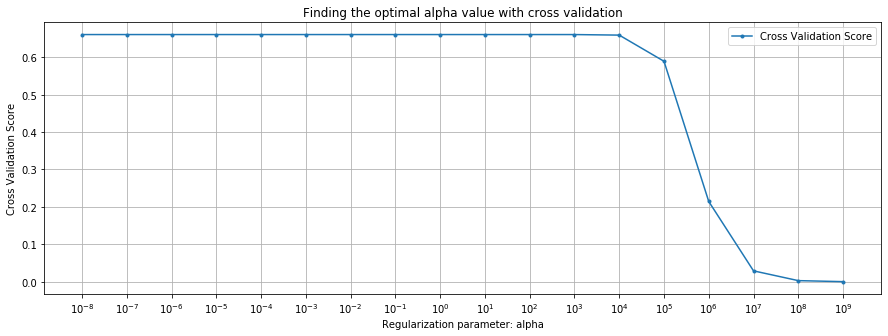

The best model has alhpa = 10.0


In [72]:
#visulize the cv score
plt.figure(figsize=(15,5))
plt.plot(alpha_range, cv_score, label ='Cross Validation Score', marker='.')
plt.legend()
plt.xscale('log')
plt.xlabel('Regularization parameter: alpha')
plt.xticks(alpha_range)
plt.ylabel('Cross Validation Score')
plt.title('Finding the optimal alpha value with cross validation')
plt.grid()
plt.show()

which_max = np.array(cv_score).argmax()
print('The best model has alhpa =', alpha_range[which_max])


In [88]:
#Score the Ridge model with alpha =10

ridge_linear_final = Ridge(alpha=10).fit(X_train_s,y_train)

print(f'Linear Regression Ridge Score on Train: {"%.4f" % ridge_linear_final.score(X_train_s, y_train)}')
print(f'Linear Regression Ridge Score on Test: {"%.4f" % ridge_linear_final.score(X_test_s, y_test)}')



Linear Regression Ridge Score on Train: 0.6609
Linear Regression Ridge Score on Test: 0.6588


In [113]:
#create a score result summary for later 
model = ['Linear_Ridge']
model_score =[0.6588]

### Lasso

In [67]:
# Using cv to find optimize alpha value for linear lasso model 
from sklearn.linear_model import Lasso

#setting up alpha range
alpha_range =np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.01,.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

#creating cv score list
cv_score_lasso = []

for b in alpha_range:
    lasso_linear = Lasso(alpha =b)
    score = cross_val_score(lasso_linear, X_train_s, y_train, cv=3).mean()
    cv_score_lasso.append(score)


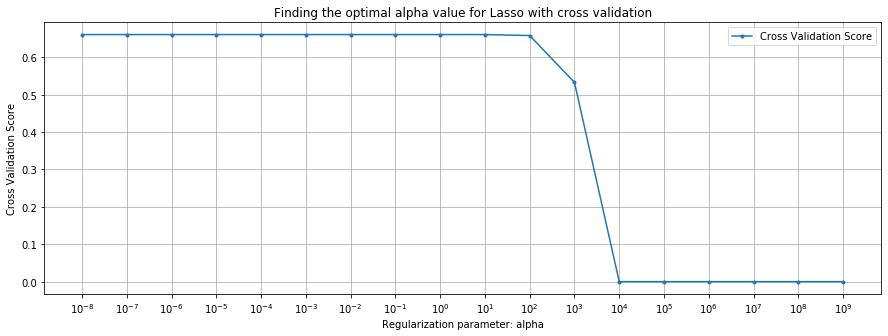

The best model has alhpa = 1e-08


In [75]:
#visulize lasso cv score
plt.figure(figsize=(15,5))
plt.plot(alpha_range, cv_score_lasso,  label ='Cross Validation Score', marker='.')
plt.legend()
plt.xscale('log')
plt.xlabel('Regularization parameter: alpha')
plt.xticks(alpha_range)
plt.ylabel('Cross Validation Score')
plt.title('Finding the optimal alpha value for Lasso with cross validation')
plt.grid()
plt.show()

which_max = np.array(cv_score_lasso).argmax()
print('The best model has alhpa =', alpha_range[which_max])

In [91]:
# Score the Lasso model with alpha = 1e-08

lasso_linear_final = Lasso(alpha=(10**(-8))).fit(X_train_s,y_train)

print(f'Linear Regression Lasso Score on Train: {"%.4f" % lasso_linear_final.score(X_train_s, y_train)}')
print(f'Linear Regression Lasso Score on Test: {"%.4f" % lasso_linear_final.score(X_test_s, y_test)}')



Linear Regression Lasso Score on Train: 0.6609
Linear Regression Lasso Score on Test: 0.6588


In [114]:
#append the result to summary for later use
model.append('Linear_Lasso')
model_score.append(0.6588)

## Decision tree regressor

In [99]:
# Simple Decision Tree with default parameter

from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor().fit(X_train, y_train)

print(f'Decision Tree Score on Train: {"%.4f" % dt.score(X_train, y_train)}')
print(f'Decision Tree Score on Test: {"%.4f" % dt.score(X_test, y_test)}')


Decision Tree Score on Train: 1.0000
Decision Tree Score on Test: 0.9282


Based on the result for both training and testing, it seems that the default setting might over fit the model. The next step I will perform is to use cross validation method to find the optimized parameters for Decision Tree Regressor. 

## Hyperparameter Tunning for Decision Tree

In [107]:
#get the parameter from default settings
display(dt)

print(f'dt default max_depth: {dt.tree_.max_depth}')

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

dt default max_depth: 110


In [115]:
# Using Cross Validation to find max_depth for the tree
#setting up depth for decision tree
depth = list(range(5,150,5))

cv_score_dt = []
for d in depth:
    dt1 = DecisionTreeRegressor(max_depth=d)
    dt_score = cross_val_score(dt1, X_train, y_train, cv=3).mean()
    cv_score_dt.append(dt_score)

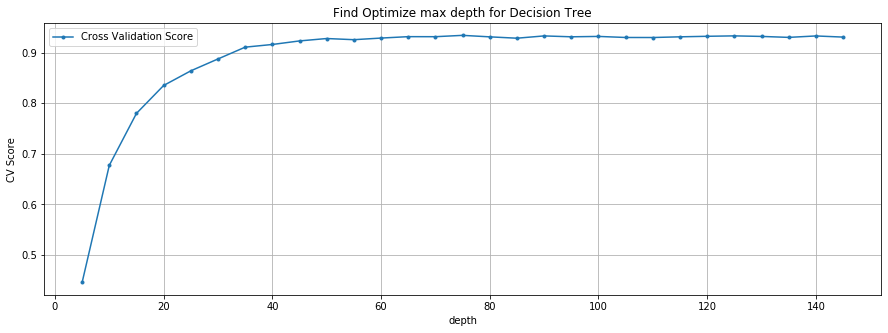

The best model has depth = 75


In [118]:
#Visulize the cv score
plt.figure(figsize=(15,5))
plt.plot(depth,cv_score_dt, label='Cross Validation Score', marker='.')
plt.title('Find Optimize max depth for Decision Tree')
plt.xlabel('depth')
plt.ylabel('CV Score')
plt.legend()
plt.grid()
plt.show()

which_max = np.array(cv_score_dt).argmax()
print('The best model has depth =', depth[which_max])

In [119]:
# Score the Lasso model with max_depth=75

dt_final = DecisionTreeRegressor(max_depth=75).fit(X_train,y_train)

print(f'Decision Tree Score on Train: {"%.4f" % dt_final.score(X_train, y_train)}')
print(f'Decision Tree Score on Test: {"%.4f" % dt_final.score(X_test, y_test)}')


Decision Tree Score on Train: 0.9998
Decision Tree Score on Test: 0.9295


In [120]:
#append the model and score
model.append('Decision Tree')
model_score.append(0.9295)

## Random Forest

In [122]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor().fit(X_train, y_train)

print(f'Random Forest Score on Train: {"%.4f" % rf.score(X_train, y_train)}')
print(f'Random Forest Score on Test: {"%.4f" % rf.score(X_test, y_test)}')


Random Forest Score on Train: 0.9926
Random Forest Score on Test: 0.9603


In [123]:
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [127]:
rf.n_estimators

10